<a href="https://colab.research.google.com/github/sl-connoryeung/gmv_forecast/blob/main/forecasting_20250324.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and Imports

In [ ]:
# Install NeuralProphet with specific dependencies
!pip install -U --no-cache-dir numpy pandas plotly neuralprophet holidays kaleido gspread gspread_dataframe --quiet

import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from warnings import simplefilter
import torch

from google.colab import auth
auth.authenticate_user()

from google.auth import default
import gspread
from gspread_dataframe import set_with_dataframe, get_as_dataframe

import bigframes.pandas as bpd
from google.cloud import bigquery

from neuralprophet import NeuralProphet, set_log_level
from google.colab import sheets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 94.2 MB/s eta 0:00:00


ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.


In [ ]:
# Suppress warnings
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
set_log_level("ERROR", "INFO")

## Configuration

In [ ]:
# Date settings
data_start_str = "2021-01-01"
data_start = pd.to_datetime(data_start_str)
data_end = (pd.Timestamp('today').normalize() - pd.Timedelta(days=5))
data_end_str = data_end.strftime('%Y-%m-%d')
forecast_end_str = "2025-12-31"
forecast_end = pd.to_datetime(forecast_end_str)

In [ ]:
# Model settings
settings = {
    "trainer_config": {
        'accelerator': 'cuda',
        'devices': 1
    }
}

## Data Loading and Preprocessing

In [ ]:
# Authentication
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
bpd.options.bigquery.project = 'shopline-hk-ops'

In [ ]:
# Query data
query = f'''
    SELECT sl_version, date AS ds, channel, gmv, orders
    FROM `shopline-hk-ops.shopline_hk_production.daily_gmv`
    WHERE date BETWEEN '{data_start_str}' AND '{data_end_str}'
      AND merchant_country = "HK"
'''
bq_df = bpd.read_gbq(query).to_pandas()

In [ ]:
# Basic preprocessing
bq_df['ds'] = pd.to_datetime(bq_df['ds'])
bq_df = bq_df.sort_values(by='ds')
bq_df['gmv'] = bq_df['gmv'].astype(float)
bq_df['orders'] = bq_df['orders'].astype(int)

In [ ]:
# Calculate AOV (Average Order Value)
bq_df['aov'] = bq_df.apply(lambda row: row['gmv'] / row['orders'] if row['orders'] > 0 else 0, axis=1)

In [ ]:
# Filter out 'others' channel
bq_df = bq_df[bq_df['channel'] != 'others']

In [ ]:
bq_df

,sl_version,ds,channel,gmv,orders,aov
1303,SL1,2021-01-01,offline,6.539271e+04,1758,37.197216
3373,SL1,2021-01-01,online,8.060408e+05,10218,78.884400
937,SL1,2021-01-02,offline,9.344213e+04,2275,41.073463
1143,SL1,2021-01-02,online,9.526511e+05,11495,82.875259
3982,SL1,2021-01-03,online,9.616786e+05,12094,79.516997
...,...,...,...,...,...,...
884,SL2,2025-04-04,online,4.345268e+04,336,129.323452
1782,SL1,2025-04-04,offline,5.654100e+05,9836,57.483738
3099,SL1,2025-04-05,online,1.736913e+06,17714,98.053101
2168,SL2,2025-04-05,online,4.661952e+04,209,223.059904


In [ ]:
# Create interactive sheet and visualizations
sheet = sheets.InteractiveSheet(df=bq_df)

https://docs.google.com/spreadsheets/d/1PjyGOnu9XBJ0Dtn8TocXl2oFY1UCAkaGsJb9l4XJM6k/edit#gid=0


In [ ]:
# Create interactive plots for GMV, Orders, and AOV
def create_plotly_visualization(df, y_col, title):
    fig = px.line(
        df, x='ds', y=y_col, color='sl_version', line_dash='channel',
        title=f'{title} over Time by SL Version and Channel',
        labels={y_col: title, 'date': 'Date'}
    )
    fig.update_layout(xaxis_rangeslider_visible=True)
    return fig

fig_gmv = create_plotly_visualization(bq_df, 'gmv', 'GMV')
fig_orders = create_plotly_visualization(bq_df, 'orders', 'Orders')
fig_aov = create_plotly_visualization(bq_df, 'aov', 'AOV')

## Events Processing and Data Preparation

In [ ]:
# Load and prepare events data
worksheet = gc.open("Festive Events & Holidays for Forecasting Model").worksheet("events")
events_df_raw = pd.DataFrame(worksheet.get_all_records())
events_df_raw = events_df_raw[events_df_raw["excluded"]!="TRUE"]

In [ ]:
# Helper function to expand event dates
def df_filldate(event_periods):
    date_df = []
    for _, row in event_periods.iterrows():
        days = pd.date_range(start=row['start_date'], end=row['end_date'])
        for day in days:
            date_df.append({'ds': day, 'event': row['event_full']})
    return pd.DataFrame(date_df)

In [ ]:
# Generate event dates and filter to relevant period
events_df = df_filldate(events_df_raw[['event_full', 'start_date', 'end_date']])
events_df = events_df[(events_df["ds"]>=data_start)&(events_df["ds"]<=forecast_end)].sort_values(by='ds', ascending=True)

In [ ]:
# Extract unique events and their parameters
unique_events = events_df_raw[['event_full', 'lower_window', 'upper_window', 'impact_additive']].drop_duplicates()

In [ ]:
# Set forecast period
forecast_start = data_end + pd.Timedelta(days=1)
forecast_periods = (forecast_end - forecast_start).days

## Data Preparation for Modeling

In [ ]:
# Create separate dataframes for Orders and AOV
df_orders = bq_df[['ds', 'sl_version', 'channel', 'orders']].copy()
df_aov = bq_df[['ds', 'sl_version', 'channel', 'aov']].copy()

In [ ]:
# Exclude SL2 data before 2024
sl2_filter = lambda df: df[~((df['sl_version'] == 'SL2') & (df['ds'] < "2024-01-01"))]
df_orders = sl2_filter(df_orders)
df_aov = sl2_filter(df_aov)

In [ ]:
# Generate all possible combinations of dates, versions, and channels
temp__sl_versions = df_orders['sl_version'].unique()
temp__channel = df_orders['channel'].unique()
temp__dates = pd.date_range(start=df_orders['ds'].min(), end=df_orders['ds'].max())

all_combinations = pd.MultiIndex.from_product(
    [temp__dates, temp__sl_versions, temp__channel],
    names=['ds', 'sl_version', 'channel']
).to_frame(index=False)

In [ ]:
# Fill in missing combinations for orders and AOV
df_orders = pd.merge(all_combinations, df_orders, on=['ds', 'sl_version', 'channel'], how='left')
df_orders['orders'] = df_orders['orders'].fillna(0)

df_aov = pd.merge(all_combinations, df_aov, on=['ds', 'sl_version', 'channel'], how='left')

In [ ]:
# Fill missing AOV values with median by segment
for sl_ver in temp__sl_versions:
    for chan in temp__channel:
        mask = (df_aov['sl_version'] == sl_ver) & (df_aov['channel'] == chan)
        median_aov = df_aov.loc[mask & df_aov['aov'].notna(), 'aov'].median()
        if not pd.isna(median_aov):
            df_aov.loc[mask & df_aov['aov'].isna(), 'aov'] = median_aov
        else:
            df_aov.loc[mask & df_aov['aov'].isna(), 'aov'] = 0

In [ ]:
# Prepare DataFrames for NeuralProphet format
def prepare_for_model(df, value_col, id_suffix):
    df['ID'] = df['sl_version'] + '_' + df['channel'] + '_' + id_suffix
    df = df.rename(columns={value_col: 'y'})
    return df[['ds', 'ID', 'y']]

df_orders = prepare_for_model(df_orders, 'orders', 'orders')
df_aov = prepare_for_model(df_aov, 'aov', 'aov')

In [ ]:
# Split data by SL version
sl1_orders = df_orders[df_orders['ID'].str.startswith('SL1_')]
sl2_orders = df_orders[df_orders['ID'].str.startswith('SL2_') & (df_orders['ds'] >= "2024-01-01")]
sl1_aov = df_aov[df_aov['ID'].str.startswith('SL1_')]
sl2_aov = df_aov[df_aov['ID'].str.startswith('SL2_') & (df_aov['ds'] >= "2024-01-01")]

## Feature Engineering and Moving Averages

In [ ]:
# Moving averages configuration
ma_sets = [3, 7, 14, 30]
ma_sets_orders = ma_sets
ma_sets_aov = [3]

In [ ]:
# Extract data for moving averages calculation
def extract_channel_data(df, id_suffix):
    online_df = df[df['ID'] == f'SL1_online_{id_suffix}'][['ds', 'y']].copy()
    offline_df = df[df['ID'] == f'SL1_offline_{id_suffix}'][['ds', 'y']].copy()

    # Calculate total
    total_df = pd.concat([online_df, offline_df])
    total_df = total_df.groupby('ds')['y'].sum().reset_index()

    # Calculate moving averages
    online_df.set_index('ds', inplace=True)
    offline_df.set_index('ds', inplace=True)

    for days in ma_sets:
        online_df[f'ma_{days}'] = online_df['y'].rolling(window=days, min_periods=1).mean()
        offline_df[f'ma_{days}'] = offline_df['y'].rolling(window=days, min_periods=1).mean()

    online_df.reset_index(inplace=True)
    offline_df.reset_index(inplace=True)

    return online_df, offline_df, total_df

In [ ]:
# Generate moving averages for orders and AOV
sl1_orders_online_df, sl1_orders_offline_df, sl1_orders_total = extract_channel_data(sl1_orders, 'orders')
sl1_aov_online_df, sl1_aov_offline_df, sl1_aov_total = extract_channel_data(sl1_aov, 'aov')

In [ ]:
# Visualize data
def plot_data_comparison(data_frames, titles, y_label, figsize=(21, 5)):
    fig, axes = plt.subplots(nrows=1, ncols=len(data_frames), figsize=figsize)
    for ax, df, title in zip(axes, data_frames, titles):
        df.plot(x='ds', y='y', ax=ax, title=title)
        ax.set_xlabel('Date')
        ax.set_ylabel(y_label)
    plt.tight_layout()
    plt.show()

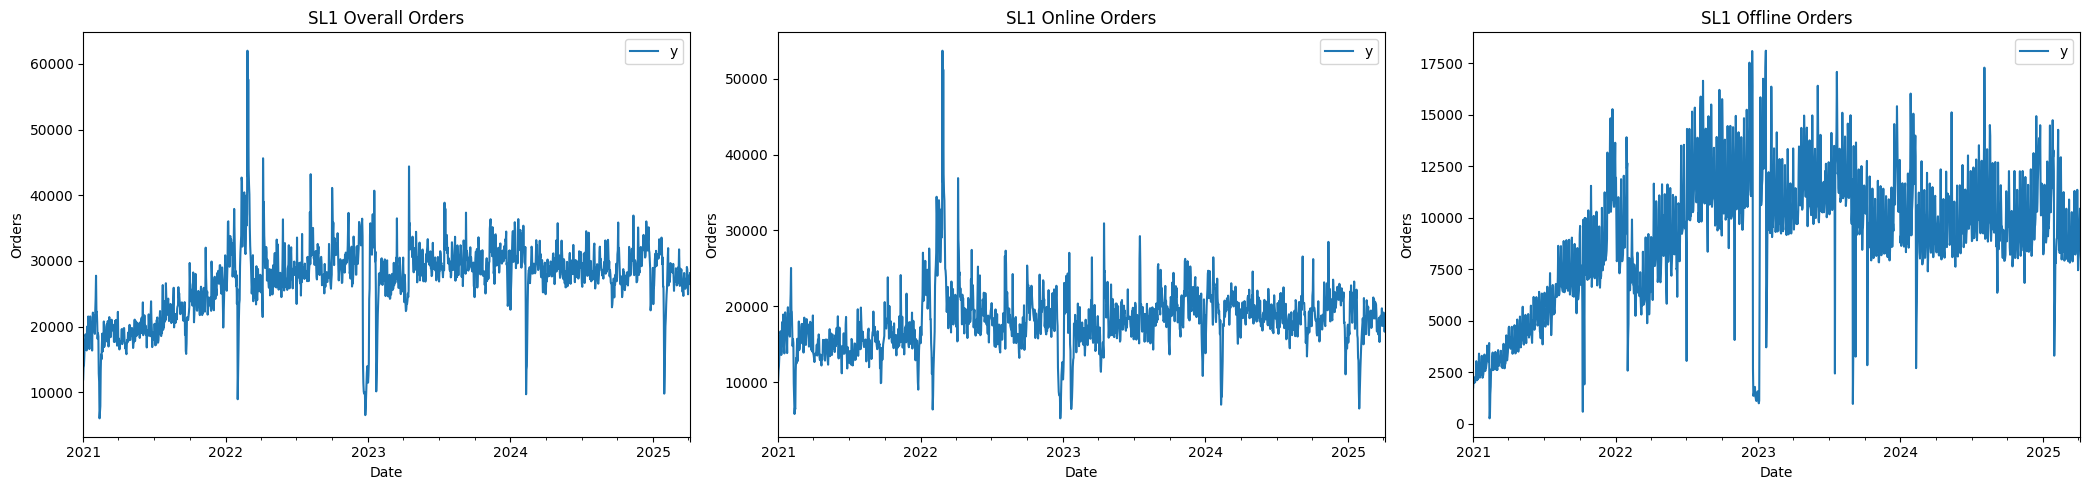

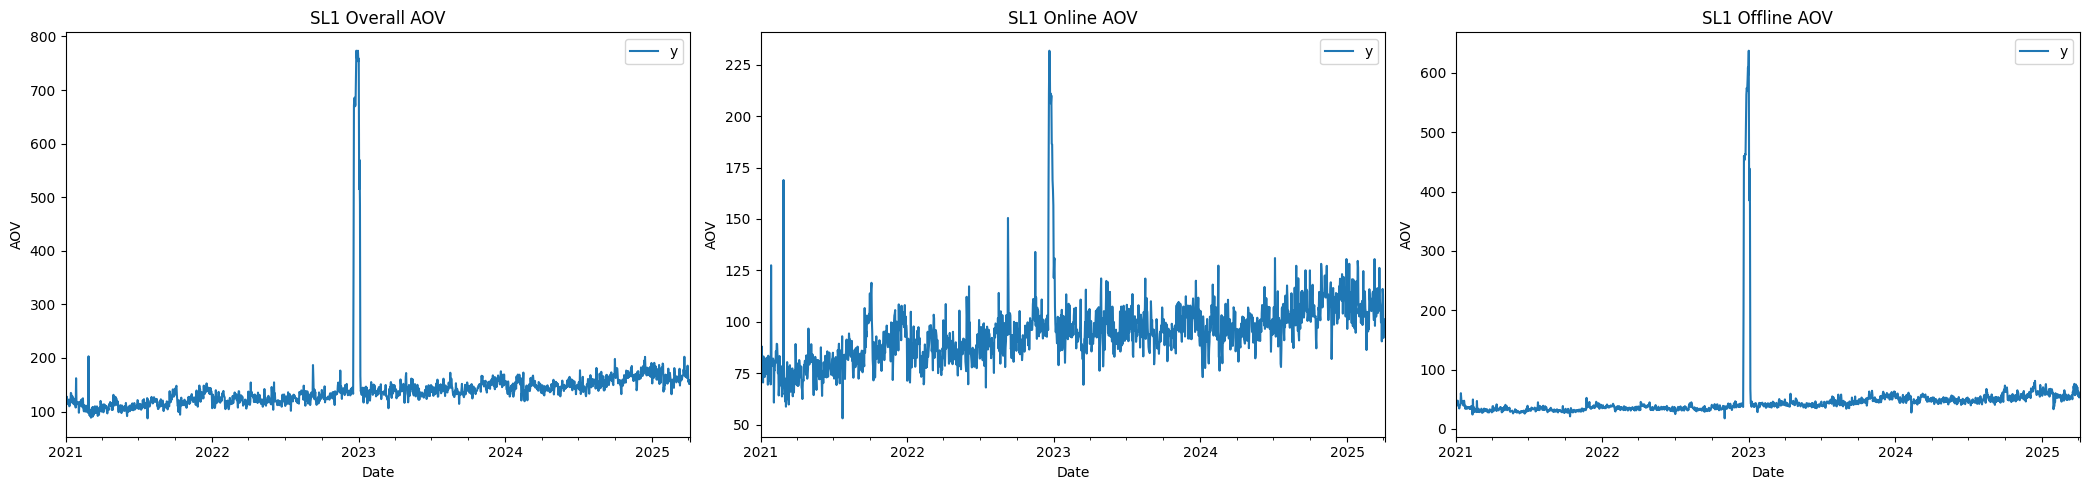

In [ ]:
# Plot orders and AOV data
plot_data_comparison(
    [sl1_orders_total, sl1_orders_online_df, sl1_orders_offline_df],
    ['SL1 Overall Orders', 'SL1 Online Orders', 'SL1 Offline Orders'],
    'Orders'
)

plot_data_comparison(
    [sl1_aov_total, sl1_aov_online_df, sl1_aov_offline_df],
    ['SL1 Overall AOV', 'SL1 Online AOV', 'SL1 Offline AOV'],
    'AOV'
)

In [ ]:
# Plot moving averages
def plot_moving_averages(data_frames, titles, y_label, ma_sets, figsize=(21, 5)):
    colors = ['blue', 'green', 'red', 'purple', 'black']
    fig, axes = plt.subplots(nrows=1, ncols=len(data_frames), figsize=figsize)

    for ax, df, title in zip(axes, data_frames, titles):
        # Plot original data
        ax.plot(df['ds'], df['y'], label=f'Original {y_label}', color='blue', alpha=0.5)
        # Plot each moving average
        for days, color in zip(ma_sets, colors):
            ax.plot(df['ds'], df[f'ma_{days}'], label=f'{days}-day MA', color=color)
        ax.set_title(title)
        ax.set_xlabel('Date')
        ax.set_ylabel(y_label)
        ax.legend()

    plt.tight_layout()
    plt.show()

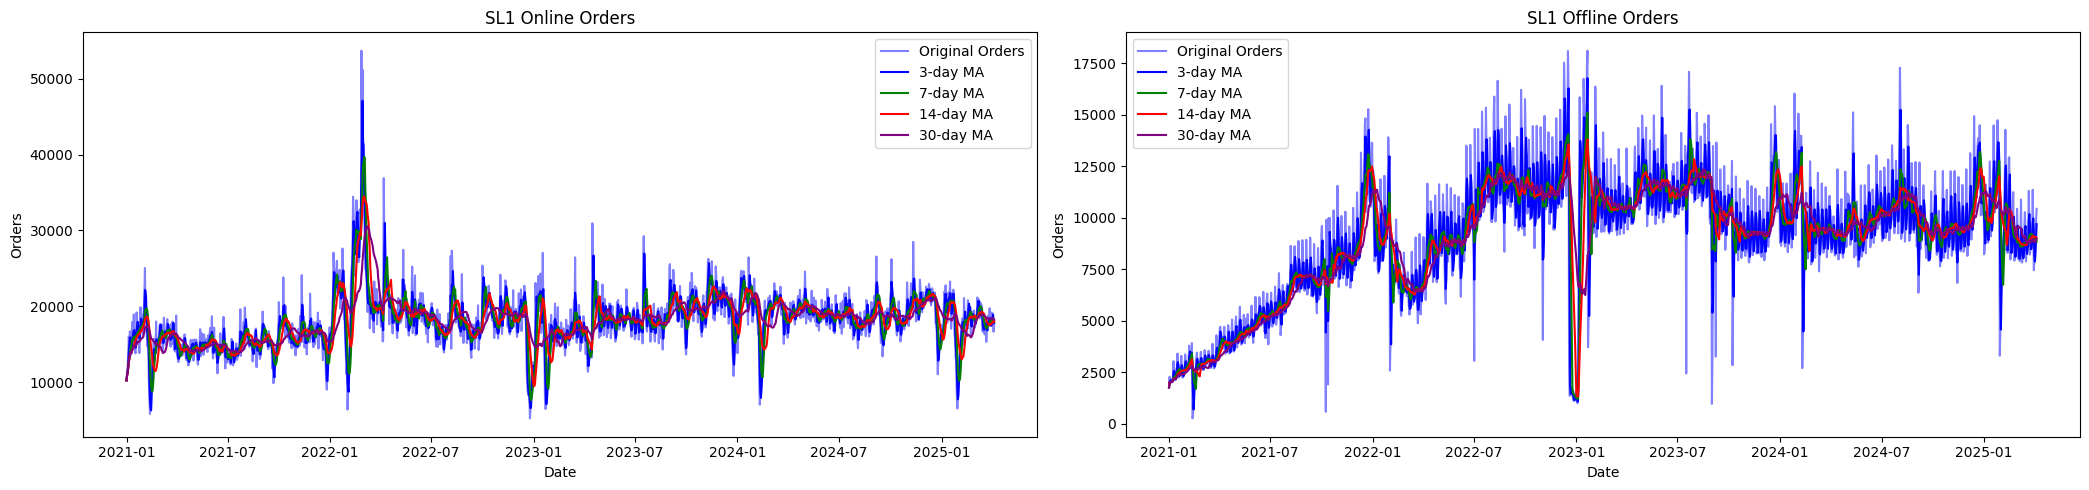

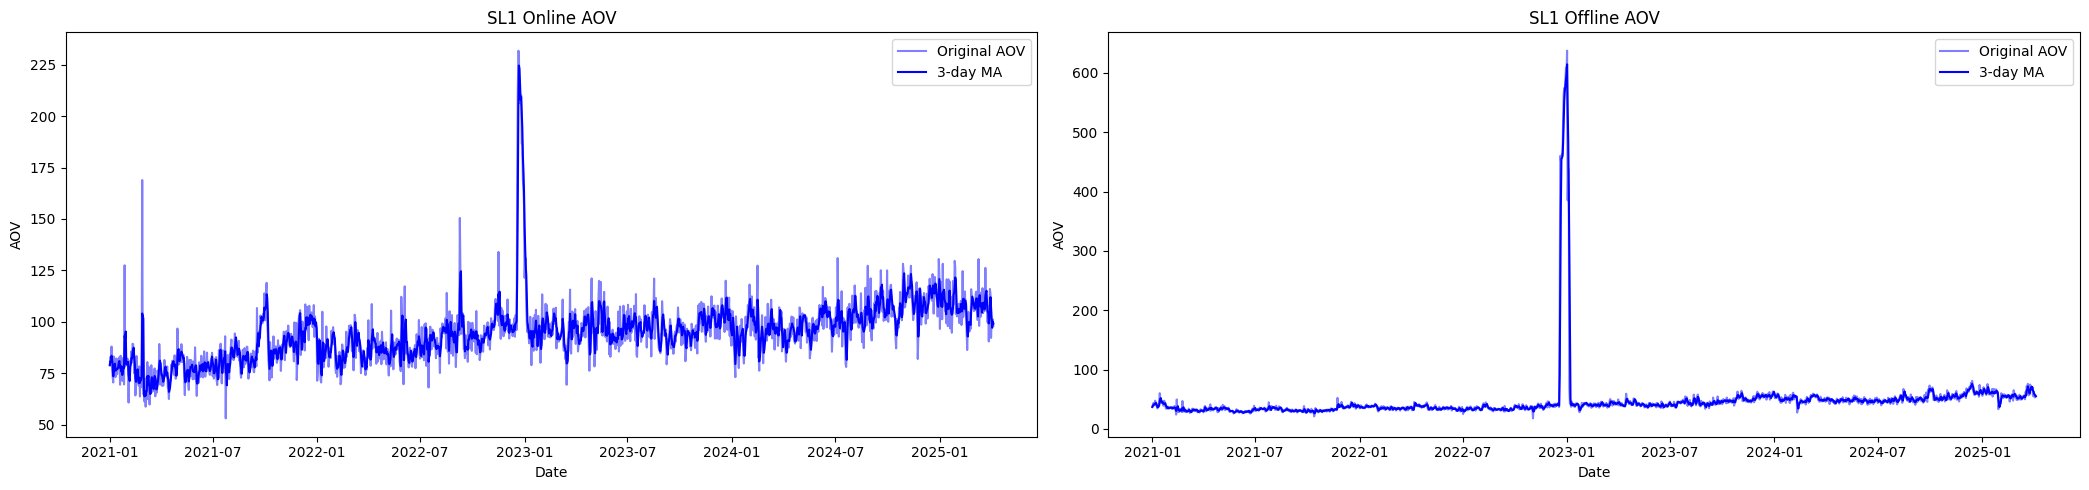

In [ ]:
# Plot moving averages for orders and AOV
plot_moving_averages(
    [sl1_orders_online_df, sl1_orders_offline_df],
    ['SL1 Online Orders', 'SL1 Offline Orders'],
    'Orders',
    ma_sets
)

plot_moving_averages(
    [sl1_aov_online_df, sl1_aov_offline_df],
    ['SL1 Online AOV', 'SL1 Offline AOV'],
    'AOV',
    ma_sets_aov
)

In [ ]:
# Add moving averages to main dataframes
def add_moving_averages(target_df, ma_dfs, ma_sets):
    for df in ma_dfs:
        for days in ma_sets:
            col_name = f'ma_{days}'
            target_df = target_df.merge(
                df[['ds', col_name]],
                on='ds',
                how='left',
                suffixes=('', '_drop')
            )
            # Remove duplicate columns created by merge
            target_df.drop([col for col in target_df if col.endswith('_drop')], axis=1, inplace=True)
    return target_df

In [ ]:
# Add moving averages to orders and AOV dataframes
sl1_orders = add_moving_averages(sl1_orders, [sl1_orders_online_df, sl1_orders_offline_df], ma_sets_orders)
sl1_aov = add_moving_averages(sl1_aov, [sl1_aov_online_df, sl1_aov_offline_df], ma_sets_aov                             )

## Modeling Functions

In [ ]:
# Create a reusable function for NeuralProphet configuration
def configure_model(is_sl1=True, include_lags=True):
    """Configure a NeuralProphet model based on whether it's for SL1 or SL2"""

    # Base configuration for SL1 models
    if is_sl1:
        model = NeuralProphet(
            trend_global_local="local",
            season_global_local="local",
            seasonality_mode="additive",
            n_lags=3 if include_lags else 0,
            n_forecasts=forecast_periods,
            trainer_config=settings['trainer_config'],
            ar_layers=[64, 64, 64, 64],
            lagged_reg_layers=[64, 64, 64, 64] if include_lags else None,
            n_changepoints=10,
            changepoints_range=0.95,
            weekly_seasonality_glocal_mode='local',
            yearly_seasonality_glocal_mode='local',
            collect_metrics={"MAPE": "MeanAbsolutePercentageError", "MAE": "MeanAbsoluteError"},
            loss_func=torch.nn.HuberLoss,
            normalize="soft1",
            quantiles=[0.6, 0.8],
        )
    # Configuration for SL2 models (less data, simpler model)
    else:
        model = NeuralProphet(
            trend_global_local="local",
            season_global_local="local",
            n_changepoints=10,
            changepoints_range=0.6,
            trend_reg=70,
            trainer_config=settings["trainer_config"],
            weekly_seasonality_glocal_mode='local',
        )

    # Common configurations
    model.set_plotting_backend("plotly-static")
    model = model.add_seasonality(name="monthly", period=30.5, fourier_order=10)

    return model

In [ ]:
# Function to add events to model
def add_events_to_model(model, events_df):
    """Add events to a NeuralProphet model"""
    for _, event in unique_events.iterrows():
        mode = "additive" if event["impact_additive"] == "TRUE" else "additive"
        model = model.add_events(
            event["event_full"],
            lower_window=event["lower_window"],
            upper_window=event["upper_window"],
            mode=mode
        )
    return model

In [ ]:
# Function to add moving averages as regressors
def add_moving_averages_to_model(model, ma_sets):
    """Add moving averages as lagged regressors to model"""
    for days in ma_sets:
        model.add_lagged_regressor(names=f'ma_{days}')
    return model

In [ ]:
# Function to train model and generate forecasts
def train_and_forecast(model, data, events_df, periods=None):
    """Train a model and generate forecasts"""
    # Prepare data with events
    data_with_events = model.create_df_with_events(data, events_df)

    # Train the model
    metrics = model.fit(data_with_events, freq="D", early_stopping=False)

    # Create future dataframe and generate forecasts
    future_df = model.make_future_dataframe(
        data_with_events,
        events_df=events_df,
        n_historic_predictions=True,
        periods=periods if periods is not None else forecast_periods,
    )

    forecast = model.predict(future_df, decompose="auto")

    return model, metrics, forecast

In [ ]:
# Function to plot model results
def plot_model_results(model, forecast, segment_ids):
    """Plot model forecasts for given segments"""
    for segment_id in segment_ids:
        model.plot(forecast[forecast["ID"] == segment_id], plotting_backend="plotly")
        model.plot_parameters(df_name=segment_id, plotting_backend="plotly")

## Model Training and Forecasting

In [ ]:
# SL1 Orders Model
orders_model = configure_model(is_sl1=True, include_lags=True)
orders_model = add_events_to_model(orders_model, events_df)
orders_model = add_moving_averages_to_model(orders_model, ma_sets)
orders_model, orders_metrics, orders_forecast = train_and_forecast(orders_model, sl1_orders, events_df)

In [ ]:
# Display model metrics
orders_metrics.tail(3)

In [ ]:
# Highlight predictions and plot results
orders_model = orders_model.highlight_nth_step_ahead_of_each_forecast(1)
plot_model_results(orders_model, orders_forecast, ["SL1_online_orders", "SL1_offline_orders"])

In [ ]:
# SL1 AOV Model
aov_model = configure_model(is_sl1=True, include_lags=True)
aov_model = add_events_to_model(aov_model, events_df)
aov_model = add_moving_averages_to_model(aov_model, ma_sets)
aov_model, aov_metrics, aov_forecast = train_and_forecast(aov_model, sl1_aov, events_df)

In [ ]:
# Display model metrics
aov_metrics.tail(3)

In [ ]:
# Highlight predictions and plot results
aov_model = aov_model.highlight_nth_step_ahead_of_each_forecast(1)
plot_model_results(aov_model, aov_forecast, ["SL1_online_aov", "SL1_offline_aov"])

In [ ]:
# SL2 Orders Model (simpler model for less data)
sl2_orders_model = configure_model(is_sl1=False, include_lags=False)
sl2_orders_model = add_events_to_model(sl2_orders_model, events_df)
sl2_orders_model, sl2_orders_metrics, sl2_orders_forecast = train_and_forecast(
    sl2_orders_model, sl2_orders, events_df, periods=forecast_periods
)

In [ ]:
# Display model metrics
sl2_orders_metrics.tail(3)

In [ ]:
# Plot results
plot_model_results(sl2_orders_model, sl2_orders_forecast, ["SL2_online_orders", "SL2_offline_orders"])

In [ ]:
# SL2 AOV Model
sl2_aov_model = configure_model(is_sl1=False, include_lags=False)
sl2_aov_model = add_events_to_model(sl2_aov_model, events_df)
sl2_aov_model, sl2_aov_metrics, sl2_aov_forecast = train_and_forecast(
    sl2_aov_model, sl2_aov, events_df, periods=forecast_periods
)

In [ ]:
# Display model metrics
sl2_aov_metrics.tail(3)

In [ ]:
# Plot results
plot_model_results(sl2_aov_model, sl2_aov_forecast, ["SL2_online_aov", "SL2_offline_aov"])

## Combining Results and Calculating GMV

In [ ]:
# Helper function to extract forecast data
def extract_forecast(model, forecast_df, id_name, include_history=True):
    """Extract the latest forecast for a specific segment"""
    segment_forecast = model.get_latest_forecast(
        forecast_df[forecast_df["ID"] == id_name],
        include_history_data=include_history
    )

    # Rename for clarity based on whether it's SL1 or SL2
    if 'SL1' in id_name:
        segment_forecast[id_name] = segment_forecast['origin-0'].combine_first(segment_forecast['y'])
    else:
        segment_forecast[id_name] = segment_forecast['yhat1'].combine_first(segment_forecast['y'])

    return segment_forecast[['ds', id_name]]

In [ ]:
# Extract all forecasts
sl1_forecasts = [
    # SL1 forecasts - extracted with get_latest_forecast
    extract_forecast(orders_model, orders_forecast, "SL1_online_orders"),
    extract_forecast(orders_model, orders_forecast, "SL1_offline_orders"),
    extract_forecast(aov_model, aov_forecast, "SL1_online_aov"),
    extract_forecast(aov_model, aov_forecast, "SL1_offline_aov")
]

In [ ]:
# Function to process SL2 forecasts
def process_sl2_forecast(forecast_df, id_name):
    return forecast_df[forecast_df["ID"] == id_name][['ds', 'yhat1', 'y']].assign(
        **{id_name: lambda df: df['yhat1'].combine_first(df['y'])}
    )[['ds', id_name]]

sl2_forecasts = [
    process_sl2_forecast(sl2_orders_forecast, "SL2_online_orders"),
    process_sl2_forecast(sl2_orders_forecast, "SL2_offline_orders"),
    process_sl2_forecast(sl2_aov_forecast, "SL2_online_aov"),
    process_sl2_forecast(sl2_aov_forecast, "SL2_offline_aov")
]

In [ ]:
# Merge all forecasts
all_forecasts = sl1_forecasts + sl2_forecasts
forecasted_df = all_forecasts[0]
for df in all_forecasts[1:]:
    forecasted_df = pd.merge(forecasted_df, df, on='ds', how='outer')

In [ ]:
# Ensure chronological order and no negative values
forecasted_df = forecasted_df.sort_values('ds')
forecasted_df[forecasted_df.select_dtypes(include=['number']).columns] = forecasted_df.select_dtypes(
    include=['number']).clip(lower=0)

In [ ]:
# Calculate GMV from Orders and AOV
forecasted_df['SL1_online_gmv'] = forecasted_df['SL1_online_orders'] * forecasted_df['SL1_online_aov']
forecasted_df['SL1_offline_gmv'] = forecasted_df['SL1_offline_orders'] * forecasted_df['SL1_offline_aov']
forecasted_df['SL2_online_gmv'] = forecasted_df['SL2_online_orders'] * forecasted_df['SL2_online_aov']
forecasted_df['SL2_offline_gmv'] = forecasted_df['SL2_offline_orders'] * forecasted_df['SL2_offline_aov']

In [ ]:
# Calculate total GMV by version and overall
forecasted_df['SL1_total_gmv'] = forecasted_df['SL1_online_gmv'] + forecasted_df['SL1_offline_gmv']
forecasted_df['SL2_total_gmv'] = forecasted_df['SL2_online_gmv'] + forecasted_df['SL2_offline_gmv']
forecasted_df['Total_gmv'] = forecasted_df['SL1_total_gmv'] + forecasted_df['SL2_total_gmv']

In [ ]:
# Display the combined dataframe
forecasted_df.head()

In [ ]:
# Visualize forecasted GMV by segment with Plotly

# Convert columns to the same data type
plot_cols = ['SL1_online_gmv', 'SL1_offline_gmv', 'SL2_online_gmv', 'SL2_offline_gmv']
for col in plot_cols:
    forecasted_df[col] = forecasted_df[col].astype(float)

# Convert to long format for plotting
plot_df = forecasted_df[['ds'] + plot_cols].melt(
    id_vars=['ds'], value_vars=plot_cols, var_name='Segment', value_name='GMV'
)

fig_segment_gmv = px.line(
    forecasted_df,
    x='ds',
    y=['SL1_online_gmv', 'SL1_offline_gmv', 'SL2_online_gmv', 'SL2_offline_gmv'],
    title='Forecasted GMV by SL Version and Channel',
    labels={'value': 'GMV', 'ds': 'Date', 'variable': 'Segment'}
)
fig_segment_gmv.update_layout(xaxis_rangeslider_visible=True)
fig_segment_gmv.show()

In [ ]:
# Visualize total GMV with Plotly
total_cols = ['SL1_total_gmv', 'SL2_total_gmv', 'Total_gmv']
for col in total_cols:
    forecasted_df[col] = forecasted_df[col].astype(float)

total_plot_df = forecasted_df[['ds'] + total_cols].melt(
    id_vars=['ds'], value_vars=total_cols, var_name='Segment', value_name='GMV'
)

fig_total_gmv = px.line(
    total_plot_df,
    x='ds',
    y='GMV',
    color='Segment',
    title='Forecasted Total GMV',
    labels={'GMV': 'GMV', 'ds': 'Date'}
)
fig_total_gmv.update_layout(xaxis_rangeslider_visible=True)
fig_total_gmv.show()

## Export Results to Google Sheets

In [ ]:
# Rearrange columns for better readability
cols_order = ['ds',
              # Orders
              'SL1_online_orders', 'SL1_offline_orders',
              'SL2_online_orders', 'SL2_offline_orders',
              # AOV
              'SL1_online_aov', 'SL1_offline_aov',
              'SL2_online_aov', 'SL2_offline_aov',
              # GMV
              'SL1_online_gmv', 'SL1_offline_gmv',
              'SL2_online_gmv', 'SL2_offline_gmv',
              # Totals
              'SL1_total_gmv', 'SL2_total_gmv', 'Total_gmv']

In [ ]:
# Apply appropriate rounding for different metrics
export_df = forecasted_df[cols_order].copy()

In [ ]:
# Format values based on metric type
def format_values(df):
    """Apply appropriate rounding for different metrics"""
    for col in df.columns:
        if col != 'ds' and df[col].dtype != 'object':
            if 'orders' in col:
                df[col] = df[col].round(0)  # Orders should be integers
            elif 'aov' in col:
                df[col] = df[col].round(1)  # AOV with 2 decimal places
            elif 'gmv' in col:
                df[col] = df[col].round(2)  # GMV with 2 decimal places
    return df

export_df = format_values(export_df)

In [ ]:
# Set up the connection to the target spreadsheet
result_spreadsheet_id = '1VblMEVPJ7arfRDlMO74MUwBRkLXft3x-I4Ga6ukkCa4'
result_worksheet_name = 'gmv_prediction_with_components'

In [ ]:
# Handle worksheet creation or update
def get_or_create_worksheet(gc, spreadsheet_id, worksheet_name, df):
    """Get existing worksheet or create a new one if it doesn't exist"""
    sh = gc.open_by_key(spreadsheet_id)
    try:
        worksheet = sh.worksheet(worksheet_name)
    except:
        worksheet = sh.add_worksheet(
            title=worksheet_name,
            rows=len(df)+10,
            cols=len(df.columns)+5
        )
    return worksheet, sh

In [ ]:
# Get worksheet and clear it
result_worksheet, sh = get_or_create_worksheet(
    gc, result_spreadsheet_id, result_worksheet_name, export_df
)
result_worksheet.clear()

In [ ]:
# Upload data
from gspread_dataframe import set_with_dataframe
set_with_dataframe(result_worksheet, export_df)

In [ ]:
# Define formatting functions
def apply_column_formatting(worksheet, columns, format_specs):
    """Apply formatting to specific columns"""
    for col_idx, col_name in enumerate(columns):
        if col_name in format_specs:
            col_letter = chr(65 + col_idx)  # A is 65 in ASCII
            worksheet.format(f'{col_letter}2:{col_letter}', format_specs[col_name])

In [ ]:
# Format the date column
date_format = {
    "numberFormat": {
        "type": "DATE",
        "pattern": "yyyy-mm-dd"
    }
}

In [ ]:
# Format for numeric columns
number_format = {
    "numberFormat": {
        "type": "NUMBER",
        "pattern": "#,##0.00"
    }
}

In [ ]:
# Apply formatting
format_specs = {'ds': date_format}
for col in cols_order:
    if col != 'ds':
        format_specs[col] = number_format

apply_column_formatting(result_worksheet, cols_order, format_specs)

In [ ]:
# Add summary statistics section
def add_summary_stats(worksheet, df, start_row):
    """Add summary statistics at the bottom of the sheet"""
    # Add header
    worksheet.update(f'A{start_row}', [['Summary Statistics']])
    worksheet.update(
        f'A{start_row+1}',
        [['Date Range', str(df['ds'].min().date()), 'to', str(df['ds'].max().date())]]
    )

    # Calculate statistics
    stat_rows = []
    stat_rows.append(['Metric', 'Min', 'Max', 'Mean', 'Median', 'Standard Deviation'])

    for col in df.columns:
        if col != 'ds':
            # Convert NumPy types to Python native types
            stats = [
                col,
                float(df[col].min()),
                float(df[col].max()),
                float(df[col].mean()),
                float(df[col].median()),
                float(df[col].std())
            ]
            stat_rows.append(stats)

    worksheet.update(f'A{start_row+3}', stat_rows)

    return start_row + 3 + len(stat_rows)

In [ ]:
# Add summary statistics
summary_row = len(export_df) + 3  # Leave a blank row after the data
add_summary_stats(result_worksheet, export_df, summary_row)

print(f"Data has been successfully saved to the '{result_worksheet_name}' worksheet.")